## Project 1: Flight Price Prediction (Regression)


In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import mlflow
import mlflow.sklearn
import warnings
import pickle
warnings.filterwarnings('ignore')

### Data Preprocessing

In [3]:
# Load the dataset

df = pd.read_csv('Flight_Price.csv')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [7]:
df.shape

(10683, 11)

In [9]:
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [7]:
#finding the null values
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [9]:
#Drop missing or nullvalues entries
df.dropna(inplace=True)

In [15]:
df.dtypes # datatypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [11]:
# Convert date and time columns
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
df['Journey_Month'] = df['Date_of_Journey'].dt.month
df['Journey_Day'] = df['Date_of_Journey'].dt.day

In [13]:
# dropping unwanted columns
df.drop('Date_of_Journey', axis=1, inplace=True)

In [15]:
# Convert departure and arrival times
df['Dep_Time'] = pd.to_datetime(df['Dep_Time']).dt.strftime('%H:%M')
df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time']).dt.strftime('%H:%M')
df['Dep_Hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
df['Dep_Minute'] = pd.to_datetime(df['Dep_Time']).dt.minute
df['Arrival_Hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
df['Arrival_Minute'] = pd.to_datetime(df['Arrival_Time']).dt.minute

In [17]:
df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Month,Journey_Day,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,IndiGo,Banglore,New Delhi,BLR ? DEL,22:20,01:10,2h 50m,non-stop,No info,3897,3,24,22,20,1,10
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25,19h,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302,3,1,16,50,21,35


In [19]:
# dropping unwanted columns
df.drop('Dep_Time', axis=1, inplace=True)
df.drop('Arrival_Time', axis=1, inplace=True)

In [21]:
# Convert duration to minutes
def convert_to_minutes(duration):
    hours = 0
    minutes = 0

    if 'h' in duration:
        hours = int(duration.split('h')[0])
        duration = duration.split('h')[1]  # Get remaining part after 'h'

    if 'm' in duration:
        minutes = int(duration.replace('m', ''))

    return hours * 60 + minutes

In [23]:
# Process duration
df['Duration_mins'] = df['Duration'].apply(convert_to_minutes)

In [25]:
df.dtypes

Airline            object
Source             object
Destination        object
Route              object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
Journey_Month       int32
Journey_Day         int32
Dep_Hour            int32
Dep_Minute          int32
Arrival_Hour        int32
Arrival_Minute      int32
Duration_mins       int64
dtype: object

### Feature engineering

In [27]:
df['Price_per_minute'] = df['Price'] / df['Duration_mins']

In [29]:
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Month,Journey_Day,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_mins,Price_per_minute
0,IndiGo,Banglore,New Delhi,BLR ? DEL,2h 50m,non-stop,No info,3897,3,24,22,20,1,10,170,22.923529
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,7h 25m,2 stops,No info,7662,5,1,5,50,13,15,445,17.217978
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,19h,2 stops,No info,13882,6,9,9,25,4,25,1140,12.177193
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,5h 25m,1 stop,No info,6218,5,12,18,5,23,30,325,19.132308
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,4h 45m,1 stop,No info,13302,3,1,16,50,21,35,285,46.673684


In [31]:
# dropping unwanted columns

df.drop('Duration', axis=1, inplace=True)

In [113]:
df.to_csv('feature.csv')

### Handling categorical data

In [33]:
#Finding the categorical value
column=[column for column in df.columns if df[column].dtype=='object']
column

['Airline', 'Source', 'Destination', 'Route', 'Total_Stops', 'Additional_Info']

In [37]:
#Finding the continuous value
continuous_col =[column for column in df.columns if df[column].dtype!='object']
continuous_col

['Price',
 'Journey_Month',
 'Journey_Day',
 'Dep_Hour',
 'Dep_Minute',
 'Arrival_Hour',
 'Arrival_Minute',
 'Duration_mins',
 'Price_per_minute']

In [39]:
categorical = df[column]
categorical.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info
0,IndiGo,Banglore,New Delhi,BLR ? DEL,non-stop,No info
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,2 stops,No info
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,2 stops,No info
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,1 stop,No info
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,1 stop,No info


In [41]:
categorical['Airline'].value_counts()

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64

<Axes: xlabel='Airline', ylabel='Price'>

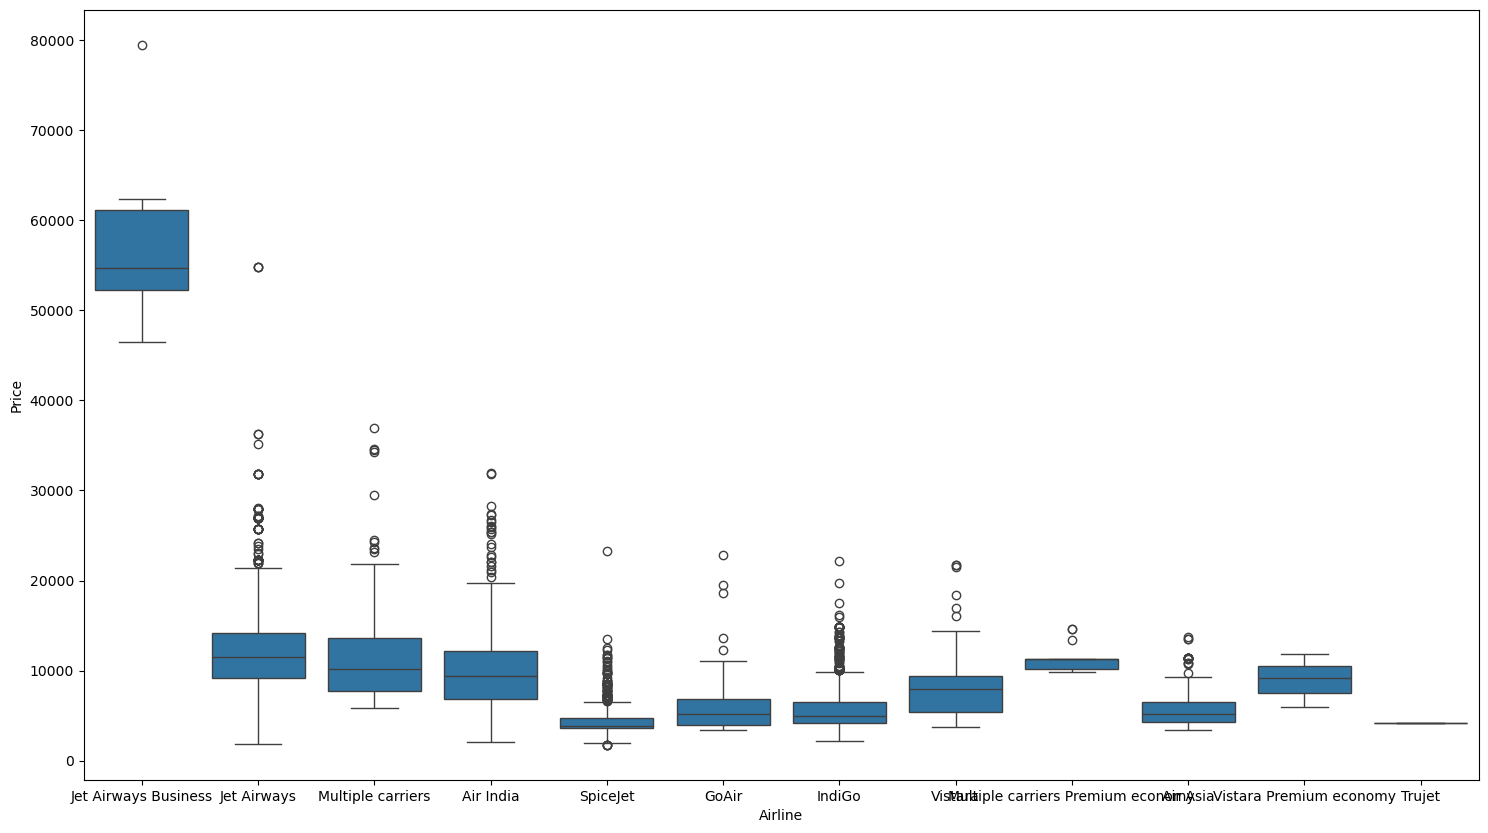

In [175]:
#Airline vs Price Analysis
plt.figure(figsize=(18,10))
sns.boxplot(x='Airline',y='Price',data=df.sort_values('Price',ascending=False))

**Observation:**
From graph we can see that Jet Airways Business have the highest Price., Apart from the first Airline almost all are having similar median

<Axes: xlabel='Total_Stops', ylabel='Price'>

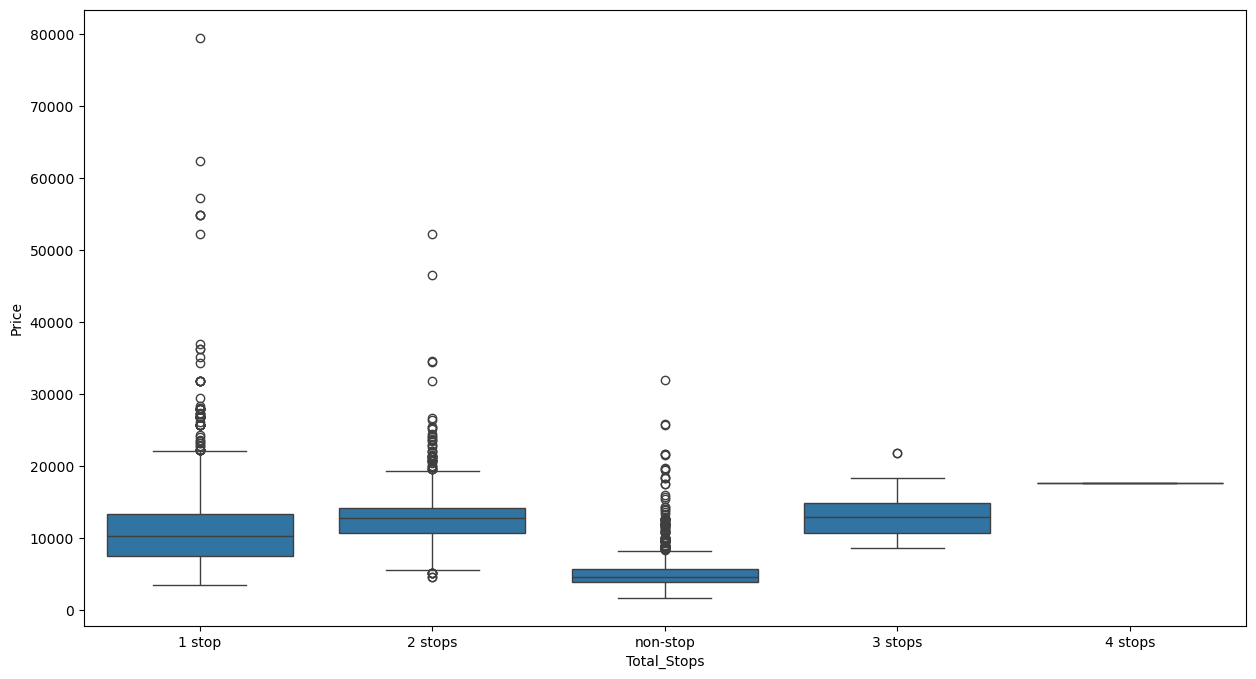

In [177]:
#Perform Total_Stops vs Price Analysis
plt.figure(figsize=(15,8))
sns.boxplot(x='Total_Stops',y='Price',data=df.sort_values('Price',ascending=False))

In [43]:
# As Airline is Nominal Categorical data we will perform OneHotEncoding
Airline=pd.get_dummies(categorical['Airline'], dtype=int, drop_first=False)

In [45]:
Airline.head()

,Air Asia,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy
0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0


In [47]:
categorical['Source'].value_counts()

Source
Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: count, dtype: int64

<Figure size 1500x1500 with 0 Axes>

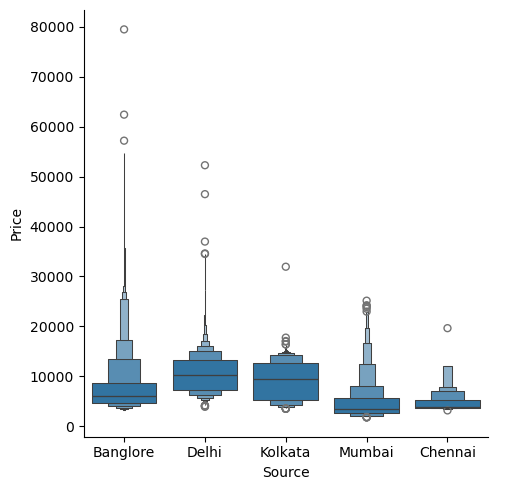

In [185]:
#Source vs Price

plt.figure(figsize=(15,15))
sns.catplot(x='Source',y='Price',data=df.sort_values('Price',ascending=False),kind='boxen')

In [49]:
#encoding of source column
source=pd.get_dummies(categorical['Source'], dtype=int,drop_first=False)
source.head()

,Banglore,Chennai,Delhi,Kolkata,Mumbai
0,1,0,0,0,0
1,0,0,0,1,0
2,0,0,1,0,0
3,0,0,0,1,0
4,1,0,0,0,0


In [51]:
categorical['Destination'].value_counts()

Destination
Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: count, dtype: int64

<Axes: xlabel='Destination', ylabel='Price'>

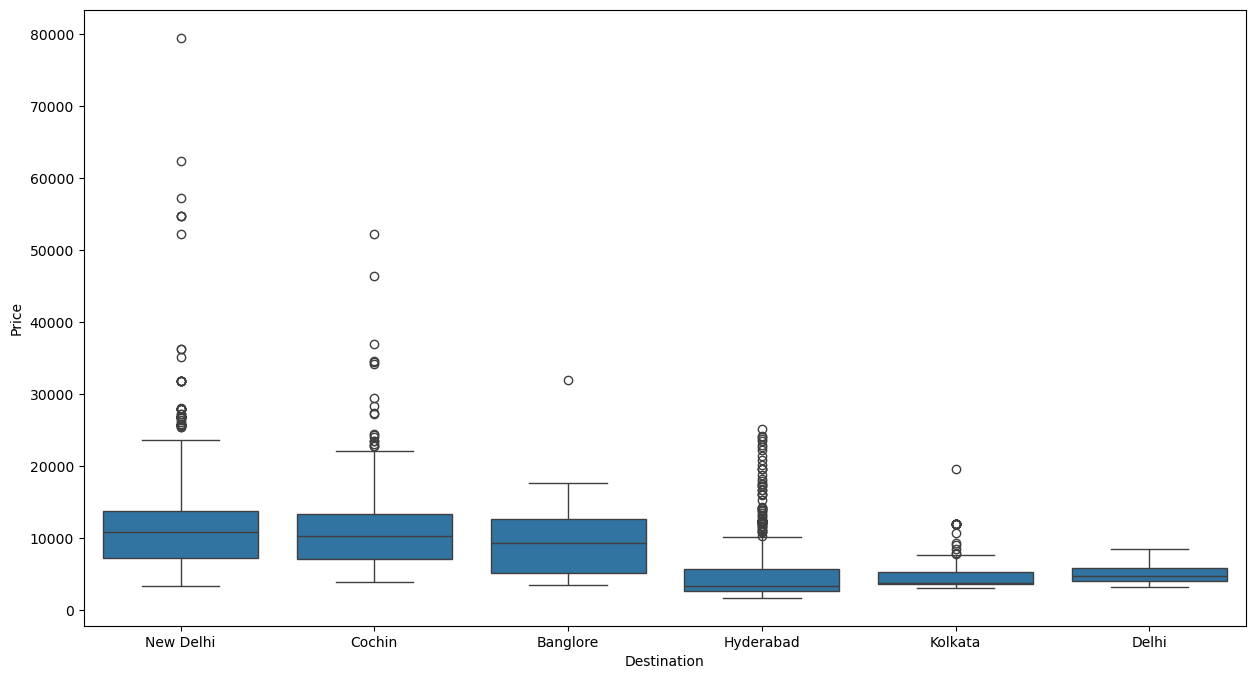

In [191]:
plt.figure(figsize=(15,8))
sns.boxplot(x='Destination',y='Price',data=df.sort_values('Price',ascending=False))

In [53]:
#encoding of destination column
destination=pd.get_dummies(categorical['Destination'], dtype=int,drop_first=False)
destination.head()

,Banglore,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,0,0,0,0,0,1
1,1,0,0,0,0,0
2,0,1,0,0,0,0
3,1,0,0,0,0,0
4,0,0,0,0,0,1


In [55]:
# Split Route into multiple columns
categorical['Route'].value_counts()

Route
DEL ? BOM ? COK          2376
BLR ? DEL                1552
CCU ? BOM ? BLR           979
CCU ? BLR                 724
BOM ? HYD                 621
                         ... 
CCU ? VTZ ? BLR             1
CCU ? IXZ ? MAA ? BLR       1
BOM ? COK ? MAA ? HYD       1
BOM ? CCU ? HYD             1
BOM ? BBI ? HYD             1
Name: count, Length: 128, dtype: int64

In [57]:
categorical['Route1']=categorical['Route'].str.split('?').str[0]
categorical['Route2']=categorical['Route'].str.split('?').str[1]
categorical['Route3']=categorical['Route'].str.split('?').str[2]
categorical['Route4']=categorical['Route'].str.split('?').str[3]
categorical['Route5']=categorical['Route'].str.split('?').str[4]

In [59]:
categorical.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Route1,Route2,Route3,Route4,Route5
0,IndiGo,Banglore,New Delhi,BLR ? DEL,non-stop,No info,BLR,DEL,NaN,NaN,NaN
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,2 stops,No info,CCU,IXR,BBI,BLR,NaN
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,2 stops,No info,DEL,LKO,BOM,COK,NaN
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,1 stop,No info,CCU,NAG,BLR,NaN,NaN
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,1 stop,No info,BLR,NAG,DEL,NaN,NaN


In [61]:
categorical.drop('Route', axis=1, inplace=True)

In [63]:
categorical.isnull().sum()

Airline                0
Source                 0
Destination            0
Total_Stops            0
Additional_Info        0
Route1                 0
Route2                 0
Route3              3491
Route4              9116
Route5             10636
dtype: int64

In [65]:
categorical.columns

Index(['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info',
       'Route1', 'Route2', 'Route3', 'Route4', 'Route5'],
      dtype='object')

In [67]:
for i in ['Route3', 'Route4', 'Route5']:
    categorical[i].fillna('None',inplace=True)

In [69]:
categorical.isnull().sum()

Airline            0
Source             0
Destination        0
Total_Stops        0
Additional_Info    0
Route1             0
Route2             0
Route3             0
Route4             0
Route5             0
dtype: int64

In [71]:
for i in categorical.columns:
    print('{} has total {} categories'.format(i,len(categorical[i].value_counts())))

Airline has total 12 categories
Source has total 5 categories
Destination has total 6 categories
Total_Stops has total 5 categories
Additional_Info has total 10 categories
Route1 has total 5 categories
Route2 has total 45 categories
Route3 has total 30 categories
Route4 has total 14 categories
Route5 has total 6 categories


<Axes: xlabel='Arrival_Hour', ylabel='Price'>

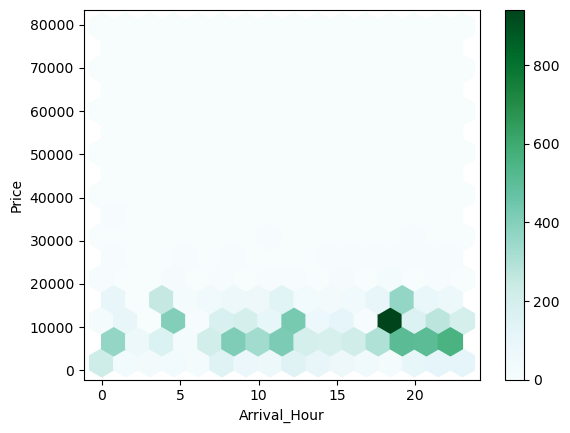

In [213]:
df.plot.hexbin(x='Arrival_Hour',y='Price',gridsize=15)

In [73]:
# Applying label encoder
encoder = LabelEncoder()

In [75]:
for i in ['Route1', 'Route2', 'Route3', 'Route4', 'Route5']:
    categorical[i]=encoder.fit_transform(categorical[i])

In [77]:
categorical.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Route1,Route2,Route3,Route4,Route5
0,IndiGo,Banglore,New Delhi,non-stop,No info,0,13,29,13,5
1,Air India,Kolkata,Banglore,2 stops,No info,2,25,1,3,5
2,Jet Airways,Delhi,Cochin,2 stops,No info,3,32,4,5,5
3,IndiGo,Kolkata,Banglore,1 stop,No info,2,34,3,13,5
4,IndiGo,Banglore,New Delhi,1 stop,No info,0,34,8,13,5


In [79]:
for i in ['Additional_Info']:
    categorical[i]=encoder.fit_transform(categorical[i])

In [81]:
categorical['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [83]:
# encoding Total stops
dict={'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}
categorical['Total_Stops']=categorical['Total_Stops'].map(dict)

In [85]:
categorical['Total_Stops']

0        0
1        2
2        2
3        1
4        1
        ..
10678    0
10679    0
10680    0
10681    0
10682    2
Name: Total_Stops, Length: 10682, dtype: int64

In [87]:
categorical.drop('Source', axis=1, inplace=True)
categorical.drop('Destination', axis=1, inplace=True)
categorical.drop('Airline', axis=1, inplace=True)

In [89]:
final_df=pd.concat([categorical,Airline,source,destination,df[continuous_col]],axis=1)

In [91]:
final_df.head()

,Total_Stops,Additional_Info,Route1,Route2,Route3,Route4,Route5,Air Asia,Air India,GoAir,...,New Delhi,Price,Journey_Month,Journey_Day,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_mins,Price_per_minute
0,0,8,0,13,29,13,5,0,0,0,...,1,3897,3,24,22,20,1,10,170,22.923529
1,2,8,2,25,1,3,5,0,1,0,...,0,7662,5,1,5,50,13,15,445,17.217978
2,2,8,3,32,4,5,5,0,0,0,...,0,13882,6,9,9,25,4,25,1140,12.177193
3,1,8,2,34,3,13,5,0,0,0,...,0,6218,5,12,18,5,23,30,325,19.132308
4,1,8,0,34,8,13,5,0,0,0,...,1,13302,3,1,16,50,21,35,285,46.673684


In [93]:
pd.set_option('display.max_columns',35)
final_df.head()

,Total_Stops,Additional_Info,Route1,Route2,Route3,Route4,Route5,Air Asia,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,...,Kolkata,Mumbai,Banglore,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,Price,Journey_Month,Journey_Day,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_mins,Price_per_minute
0,0,8,0,13,29,13,5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3897,3,24,22,20,1,10,170,22.923529
1,2,8,2,25,1,3,5,0,1,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,7662,5,1,5,50,13,15,445,17.217978
2,2,8,3,32,4,5,5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,13882,6,9,9,25,4,25,1140,12.177193
3,1,8,2,34,3,13,5,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,6218,5,12,18,5,23,30,325,19.132308
4,1,8,0,34,8,13,5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,13302,3,1,16,50,21,35,285,46.673684


### EDA

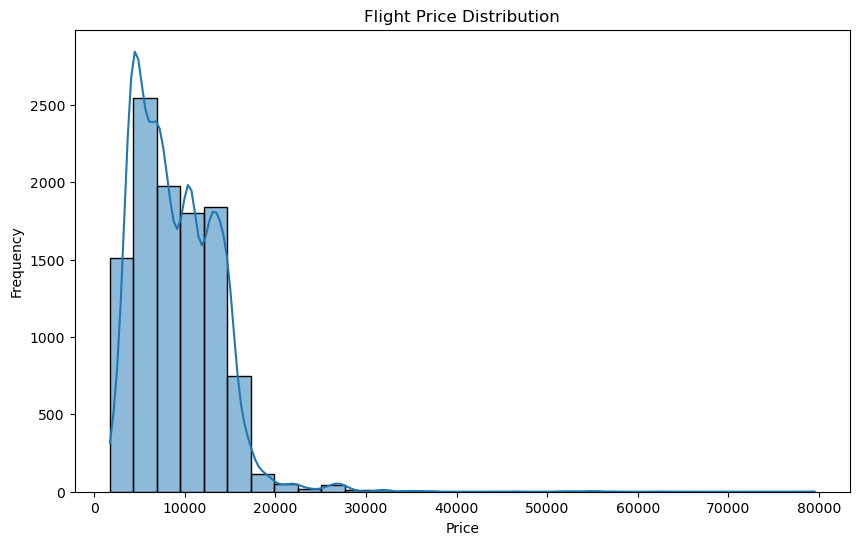

In [382]:
# Plot flight price distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=30, kde=True)
plt.title('Flight Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

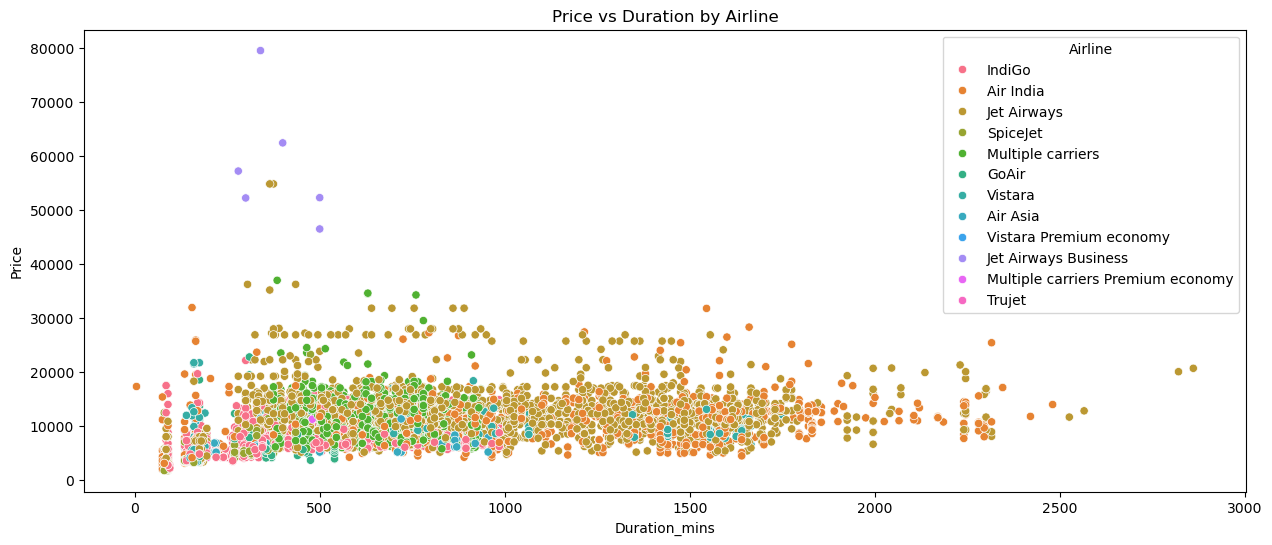

In [386]:
# Price vs Duration by Airline
plt.figure(figsize=(15, 6))
sns.scatterplot(data=df, x='Duration_mins', y='Price', hue='Airline')
plt.title('Price vs Duration by Airline')
plt.show()

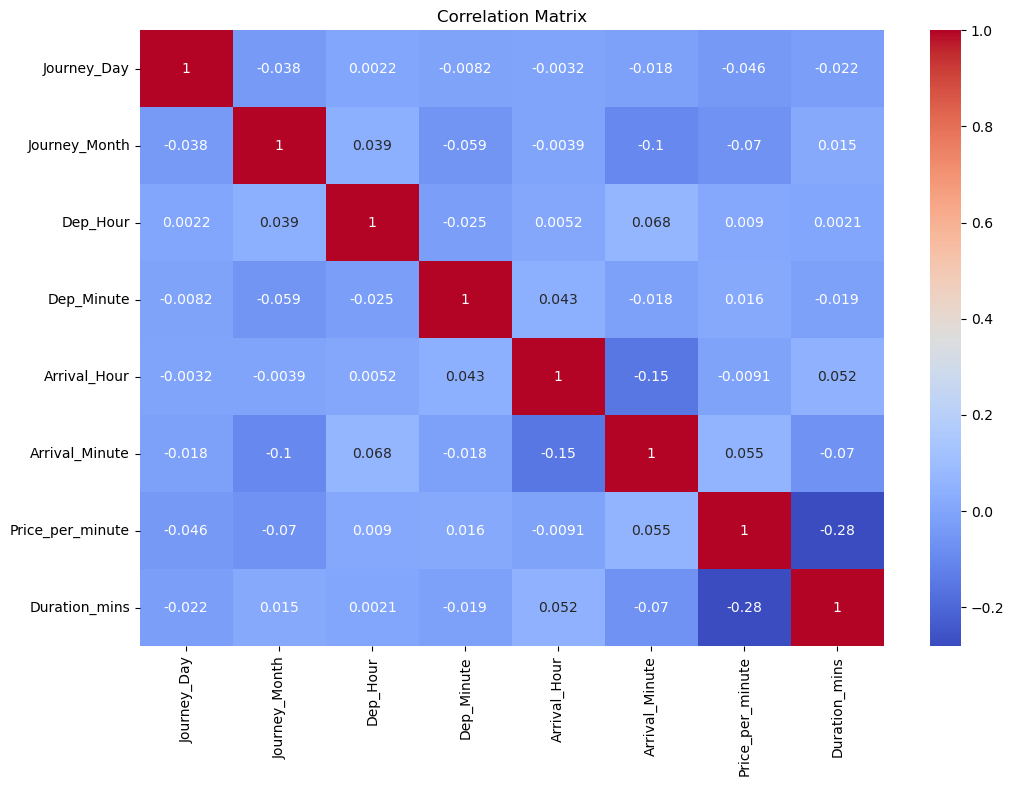

In [388]:
# Correlation heatmap
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [392]:
# Top 6 Most Expensive and Cheapest Routes
route_prices = df.groupby(['Source', 'Destination'])['Price'].mean().reset_index()
top_expensive = route_prices.nlargest(10, 'Price')
top_cheapest = route_prices.nsmallest(10, 'Price')

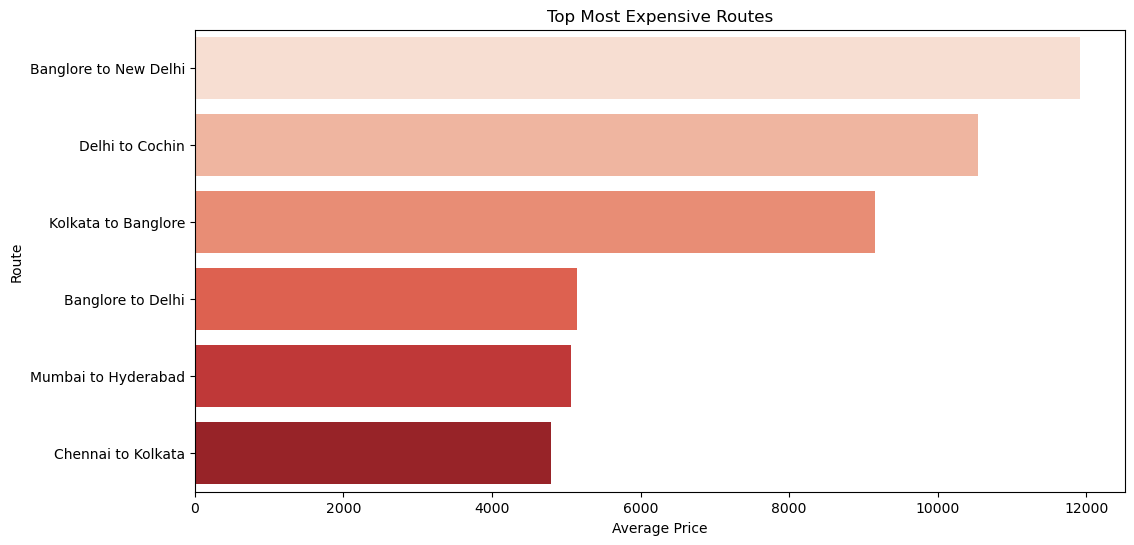

In [394]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Price', y='Route', data=top_expensive.assign(Route=top_expensive['Source'] + ' to ' + top_expensive['Destination']), palette='Reds')
plt.title('Top Most Expensive Routes')
plt.xlabel('Average Price')
plt.ylabel('Route')
plt.show()

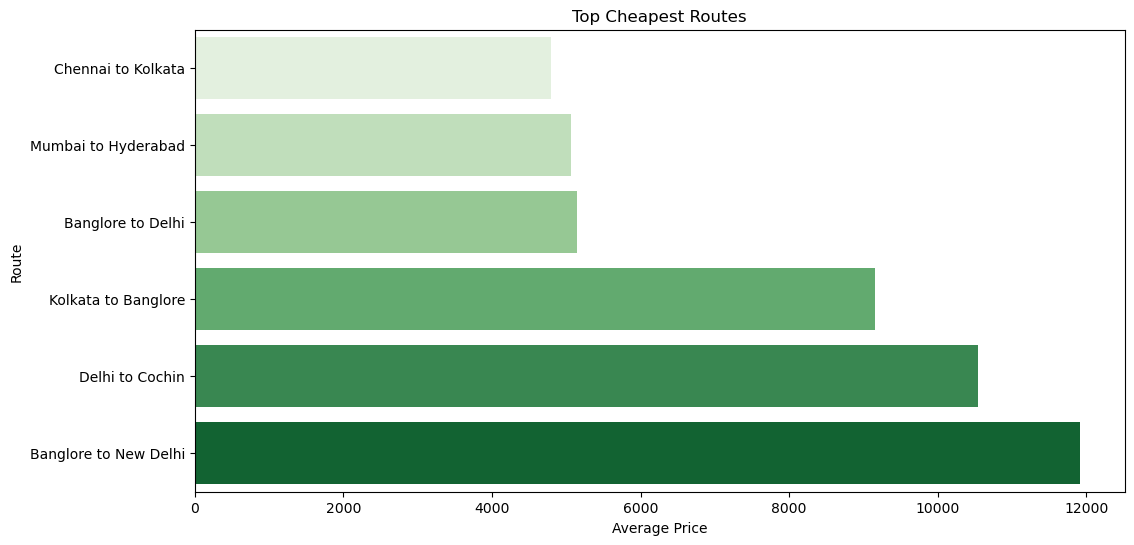

In [396]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Price', y='Route', data=top_cheapest.assign(Route=top_cheapest['Source'] + ' to ' + top_cheapest['Destination']), palette='Greens')
plt.title('Top Cheapest Routes')
plt.xlabel('Average Price')
plt.ylabel('Route')
plt.show()

In [95]:
# Seperate the dataset in X and Y columns
X=final_df.drop('Price',axis=1)
y=df['Price']

In [97]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso()
}

In [101]:
# Hyperparameter grids
param_grids = {
    'Random Forest': {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5]
    },
    'XGBoost': {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__max_depth': [3, 6]
    },
    'Gradient Boosting': {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__max_depth': [3, 6]
    },
    'SVR': {
        'regressor__C': [0.1, 1, 10],
        'regressor__kernel': ['linear', 'rbf']
    },
    'Decision Tree': {
        'regressor__max_depth': [None, 10, 20]
    },
    'Ridge Regression': {
        'regressor__alpha': [0.1, 1, 10]
    },
    'Lasso Regression': {
        'regressor__alpha': [0.1, 1, 10]
    }
}

In [103]:
# Initialize MLflow
mlflow.set_experiment("Flight: Price Prediction")
trained_models = {}
best_model = None
best_r2 = float('-inf')

Training Linear Regression...

Linear Regression Performance:
  RMSE: 2594.9677
  MAE: 1741.9299
  R² Score: 0.6877
----------------------------------------


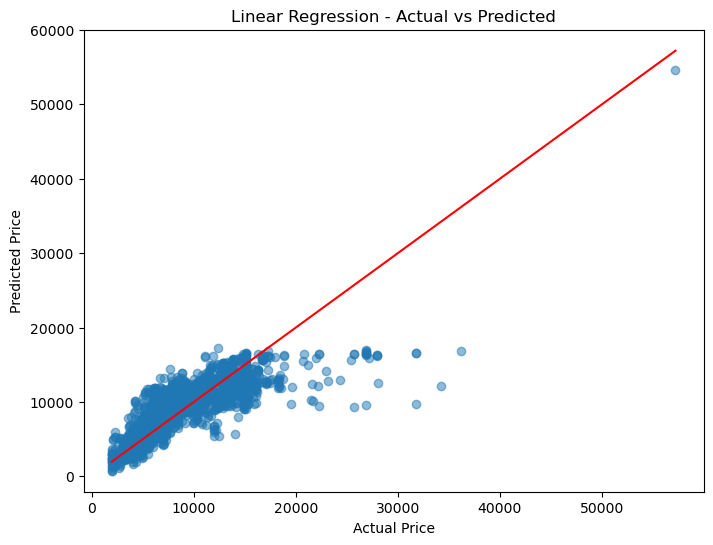

2025/03/09 10:22:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Random Forest...

Random Forest Performance:
  RMSE: 690.8630
  MAE: 114.7185
  R² Score: 0.9779
----------------------------------------


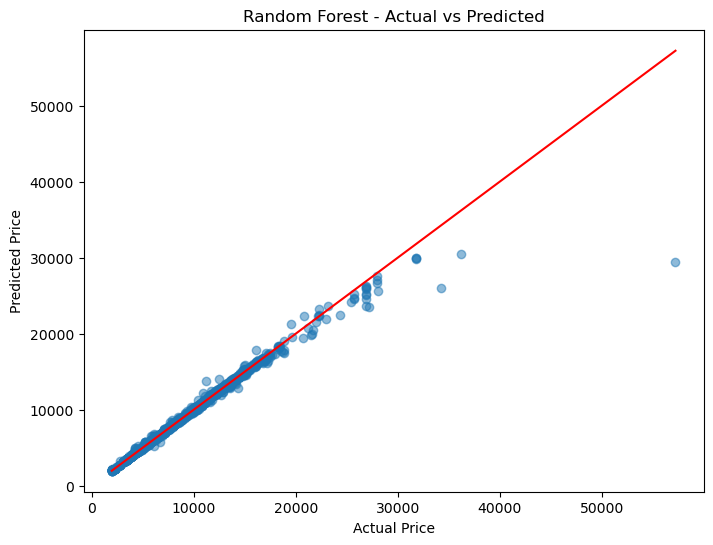

Tuning Random Forest...
Best params for Random Forest: {'regressor__max_depth': 20, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}

Random Forest Performance after Tuning:
  RMSE: 694.1195
  MAE: 112.7644
  R² Score: 0.9777
----------------------------------------


2025/03/09 10:26:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training XGBoost...

XGBoost Performance:
  RMSE: 490.9362
  MAE: 178.6018
  R² Score: 0.9888
----------------------------------------


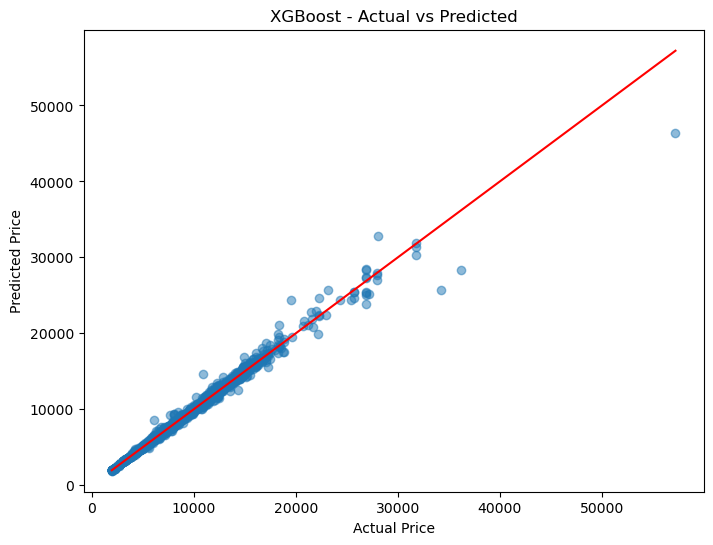

Tuning XGBoost...
Best params for XGBoost: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}

XGBoost Performance after Tuning:
  RMSE: 548.7077
  MAE: 303.9566
  R² Score: 0.9860
----------------------------------------


2025/03/09 10:26:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Gradient Boosting...

Gradient Boosting Performance:
  RMSE: 668.3036
  MAE: 397.2739
  R² Score: 0.9793
----------------------------------------


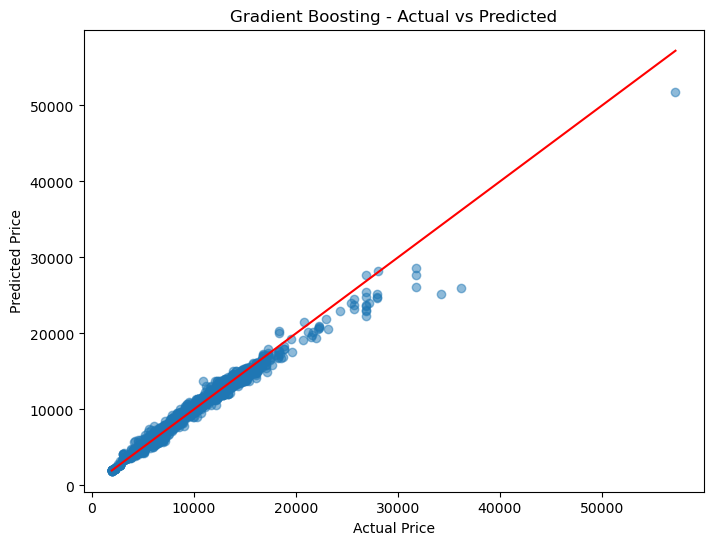

Tuning Gradient Boosting...
Best params for Gradient Boosting: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__n_estimators': 200}

Gradient Boosting Performance after Tuning:
  RMSE: 424.6225
  MAE: 131.4389
  R² Score: 0.9916
----------------------------------------


2025/03/09 10:27:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training SVR...

SVR Performance:
  RMSE: 4511.2069
  MAE: 3404.8877
  R² Score: 0.0562
----------------------------------------


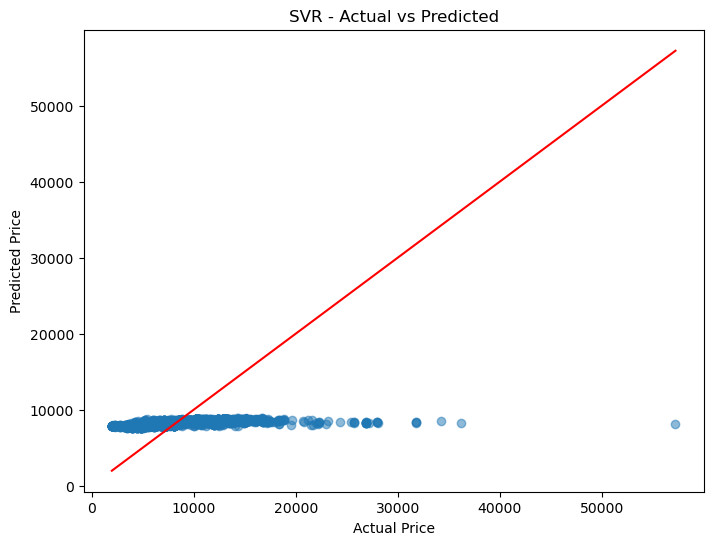

Tuning SVR...
Best params for SVR: {'regressor__C': 1, 'regressor__kernel': 'linear'}

SVR Performance after Tuning:
  RMSE: 2931.2921
  MAE: 1753.0128
  R² Score: 0.6015
----------------------------------------


2025/03/09 10:28:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Decision Tree...

Decision Tree Performance:
  RMSE: 471.5995
  MAE: 136.0117
  R² Score: 0.9897
----------------------------------------


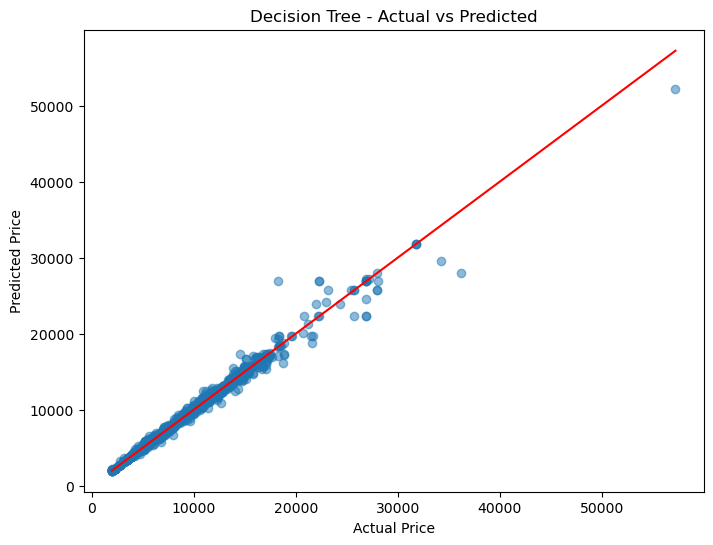

Tuning Decision Tree...
Best params for Decision Tree: {'regressor__max_depth': None}

Decision Tree Performance after Tuning:
  RMSE: 471.5995
  MAE: 136.0117
  R² Score: 0.9897
----------------------------------------


2025/03/09 10:29:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Ridge Regression...

Ridge Regression Performance:
  RMSE: 2594.9157
  MAE: 1741.9194
  R² Score: 0.6877
----------------------------------------


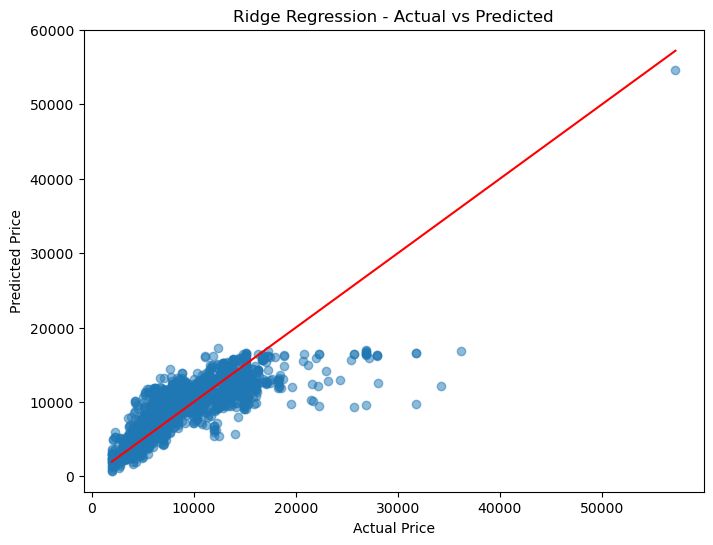

Tuning Ridge Regression...
Best params for Ridge Regression: {'regressor__alpha': 10}

Ridge Regression Performance after Tuning:
  RMSE: 2594.5229
  MAE: 1741.8308
  R² Score: 0.6878
----------------------------------------


2025/03/09 10:29:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Lasso Regression...

Lasso Regression Performance:
  RMSE: 2595.0584
  MAE: 1741.7350
  R² Score: 0.6877
----------------------------------------


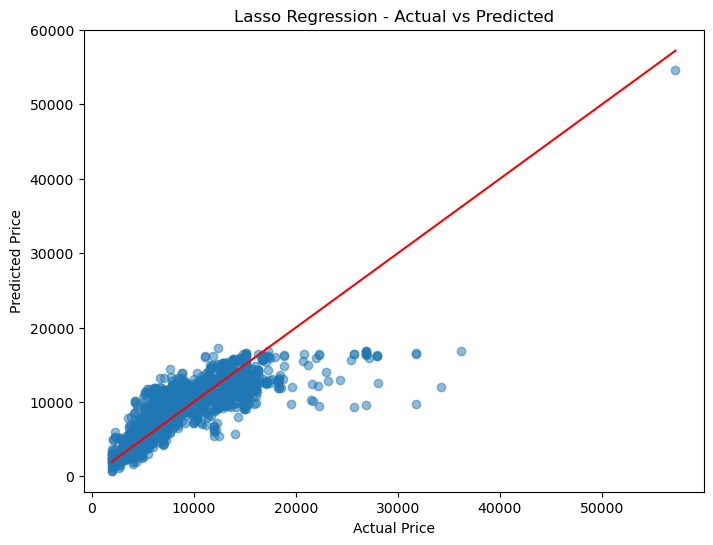

Tuning Lasso Regression...
Best params for Lasso Regression: {'regressor__alpha': 10}

Lasso Regression Performance after Tuning:
  RMSE: 2596.7746
  MAE: 1740.6223
  R² Score: 0.6873
----------------------------------------


2025/03/09 10:29:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Model: Gradient Boosting with R²: 0.99
All models trained, tuned, and logged in MLflow!


In [105]:
# Train, tune, save, and track models
for name, model in models.items():
    print(f"Training {name}...")
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    
    # Train model
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print("-" * 40)
    
    # Track best model based on R²
    if r2 > best_r2:
        best_r2 = r2
        best_model = name
    
    # Plot actual vs predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"{name} - Actual vs Predicted")
    plt.show()
    
    # Hyperparameter tuning (if applicable)
    if name in param_grids:
        print(f"Tuning {name}...")
        grid_search = GridSearchCV(pipeline, param_grid=param_grids[name], scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        pipeline = grid_search.best_estimator_
        y_pred = pipeline.predict(X_test)
        
        # Re-evaluate
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"Best params for {name}: {grid_search.best_params_}")
        print(f"\n{name} Performance after Tuning:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  R² Score: {r2:.4f}")
        print("-" * 40)
        
        # Track best model again after tuning
        if r2 > best_r2:
            best_r2 = r2
            best_model = name
    
    # Log experiment in MLflow
    with mlflow.start_run(run_name=name):
        if name in param_grids:
            for param, value in grid_search.best_params_.items():
                mlflow.log_param(param, value)
        
        mlflow.log_metrics({"RMSE": rmse, "MAE": mae, "R2": r2})
        mlflow.sklearn.log_model(pipeline, name)
    
    # Save model
    trained_models[name] = pipeline
    with open(f"{name}_pipeline.pkl", "wb") as f:
        pickle.dump(pipeline, f)

print(f"Best Model: {best_model} with R²: {best_r2:.2f}")
print("All models trained, tuned, and logged in MLflow!")

In [107]:
final_df.head()

,Total_Stops,Additional_Info,Route1,Route2,Route3,Route4,Route5,Air Asia,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,...,Kolkata,Mumbai,Banglore,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,Price,Journey_Month,Journey_Day,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_mins,Price_per_minute
0,0,8,0,13,29,13,5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3897,3,24,22,20,1,10,170,22.923529
1,2,8,2,25,1,3,5,0,1,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,7662,5,1,5,50,13,15,445,17.217978
2,2,8,3,32,4,5,5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,13882,6,9,9,25,4,25,1140,12.177193
3,1,8,2,34,3,13,5,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,6218,5,12,18,5,23,30,325,19.132308
4,1,8,0,34,8,13,5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,13302,3,1,16,50,21,35,285,46.673684


In [109]:
final_df.info

<bound method DataFrame.info of        Total_Stops  Additional_Info  Route1  Route2  Route3  Route4  Route5  \
0                0                8       0      13      29      13       5   
1                2                8       2      25       1       3       5   
2                2                8       3      32       4       5       5   
3                1                8       2      34       3      13       5   
4                1                8       0      34       8      13       5   
...            ...              ...     ...     ...     ...     ...     ...   
10678            0                8       2       5      29      13       5   
10679            0                8       2       5      29      13       5   
10680            0                8       0      13      29      13       5   
10681            0                8       0      13      29      13       5   
10682            2                8       3      16       4       5       5   

       Air Asia  Ai

In [111]:
final_df.to_csv('Cleaned.csv')